In [2]:
%load_ext autoreload

In [5]:
%autoreload 2
import os
os.chdir(os.path.expanduser("/notebooks/segmentation"))
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F

from PIL import Image
import PIL

from train_utils.utils import mIoU, Lion
from plotter.plot import plot_prediction
from train_utils.unet_pipeline_trainer import train

from batchflow import batchflow as bf
from batchflow.batchflow import B, M, V, C, Notifier, Pipeline, Dataset
from batchflow.batchflow.models.torch.unet import UNet as Unet_bf
from batchflow.batchflow.models.torch import TorchModel
from batchflow.batchflow.opensets.ade import ADESegmentation
from batchflow.batchflow.plotter.plot import plot

import warnings
warnings.filterwarnings("ignore")

In [1]:
train_params = {
    'BATCH_SIZE': 16,
    'LR': 1e-4,
    'NUM_CLASSES': 151,
    'NUM_EPOCHS': 90,
    'IMAGE_SHAPE': (256, 256)
}

In [4]:
dataset = ADESegmentation()
dataset.split([0.7, 0.2, 0.1], shuffle=True)

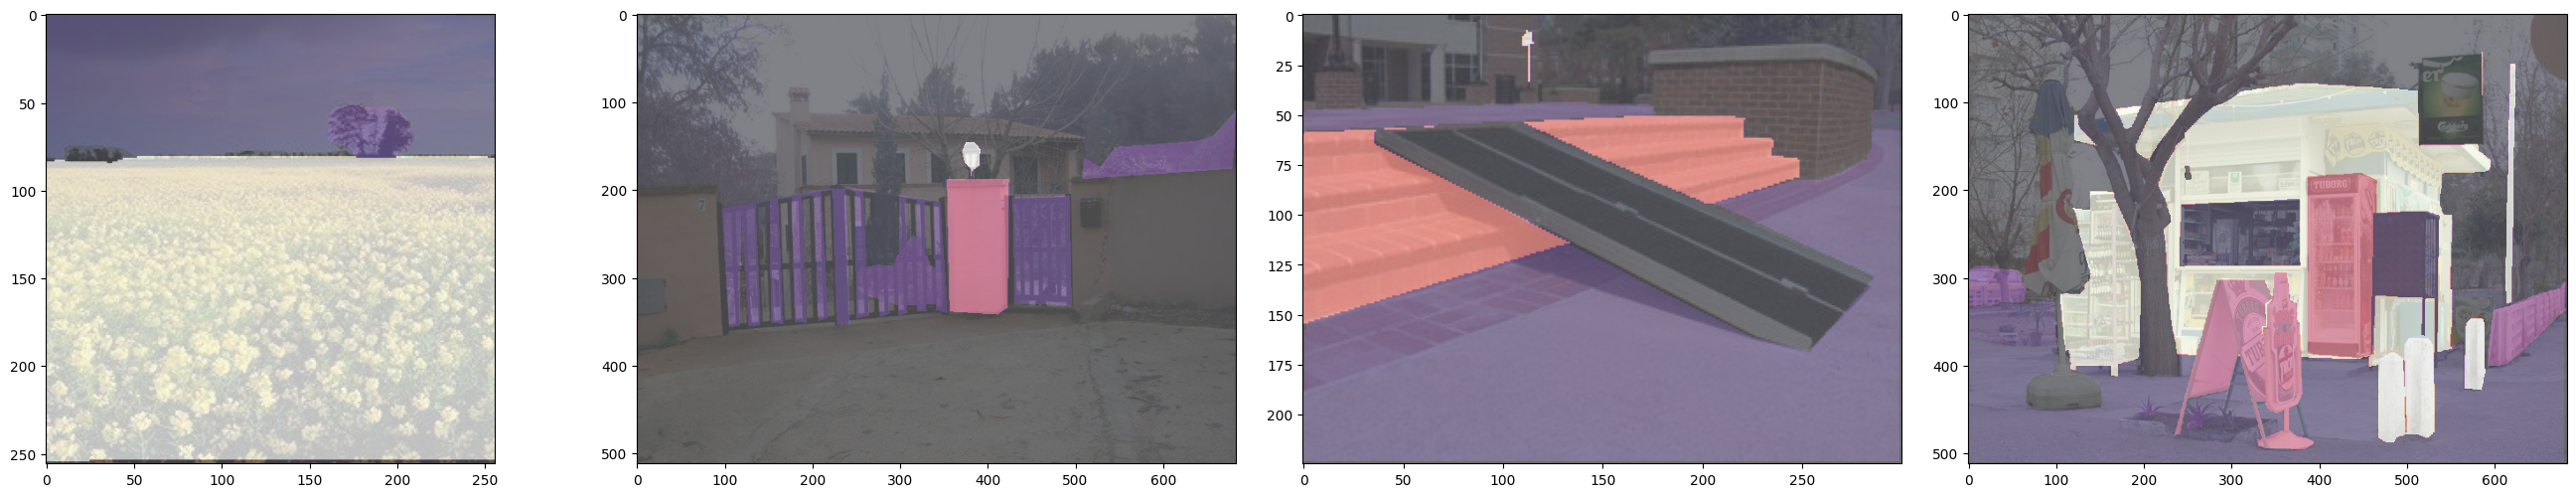

In [24]:
plot(
    data=[[np.array(dataset.images[0]), np.array(dataset.labels[0])], 
          [np.array(dataset.images[1]), np.array(dataset.labels[1])], 
          [np.array(dataset.images[2]), np.array(dataset.labels[2])],
          [np.array(dataset.images[3]), np.array(dataset.labels[3])]],
    cmap='batchflow',
    alpha=0.5
)

In [5]:
config = Unet_bf.default_config()

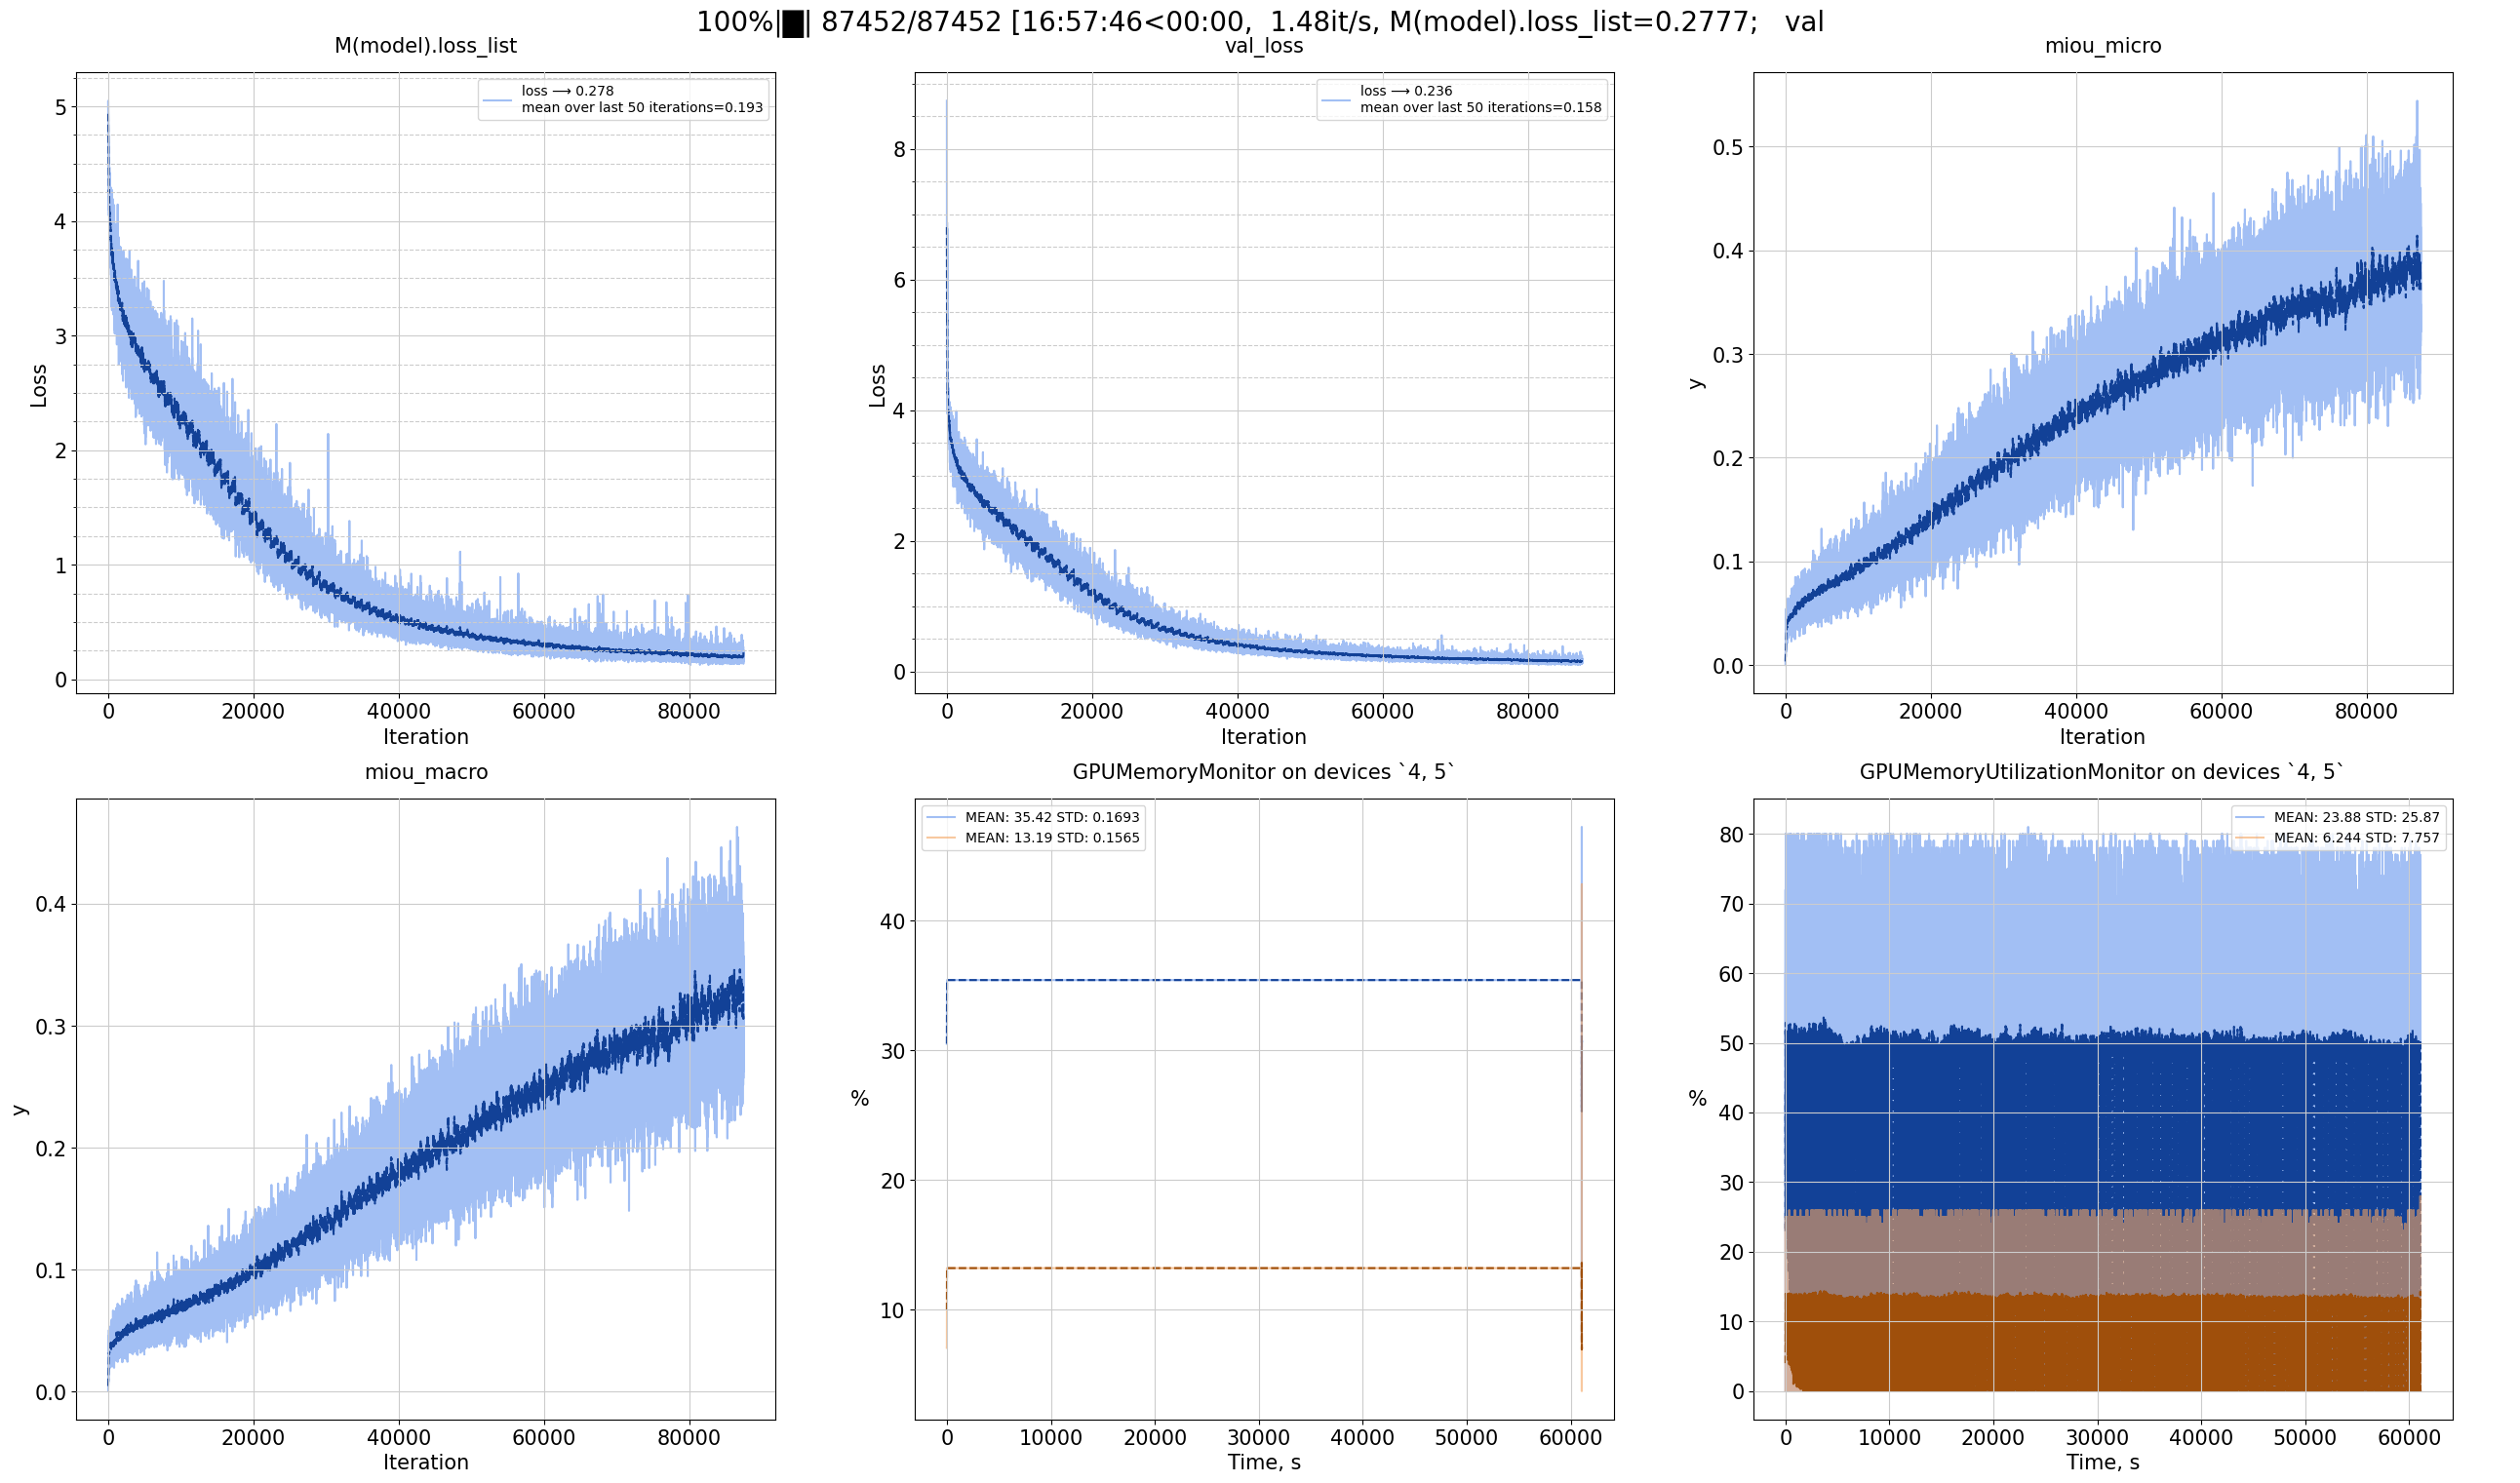

In [6]:
train_val_pipeline = train(
    dataset=dataset,
    config=config,
    loss={'name':' ce', 'squeeze': True, 'ignore_index': 255, 'weight': 'adaptive'},
    optimizer={'name': Lion, 'lr': train_params['LR']},
    train_params=train_params,
    visible_devices='4,5',
    frequency=100
)

In [7]:
test_pipeline = (
    Pipeline()
    .import_model('model', train_val_pipeline)
    .init_variable('images', [])
    .init_variable('predictions', [])
    .init_variable('masks', [])
    .init_variable('iou', [])

    .resize(size=train_params['IMAGE_SHAPE'], resample=Image.Resampling.BILINEAR, src='images', dst='images')
    .to_array(channels='first', dtype=np.float32, src='images', dst='images')

    .resize(size=train_params['IMAGE_SHAPE'], resample=Image.Resampling.NEAREST, src='labels', dst='masks')
    .to_array(channels='first', dtype=np.int64, src='masks', dst='masks')

    .predict_model('model', inputs=B.images,
                   outputs='predictions', save_to=V('predictions', mode='a'))
    .update(V('images', mode='a'), B.images)
    .update(V('masks', mode='a'), B.masks)
    .mIoU(preds=V.predictions[-1], mask=B('masks'), num_classes=train_params['NUM_CLASSES'], save_to=V('iou', mode='a'))
) << dataset.test

test_pipeline = test_pipeline.run(batch_size=1, shuffle=False, n_epochs=1, drop_last=False, bar=True)

  0%|                                                                                                         …

In [8]:
np.mean(test_pipeline.v('iou'))

0.1142178

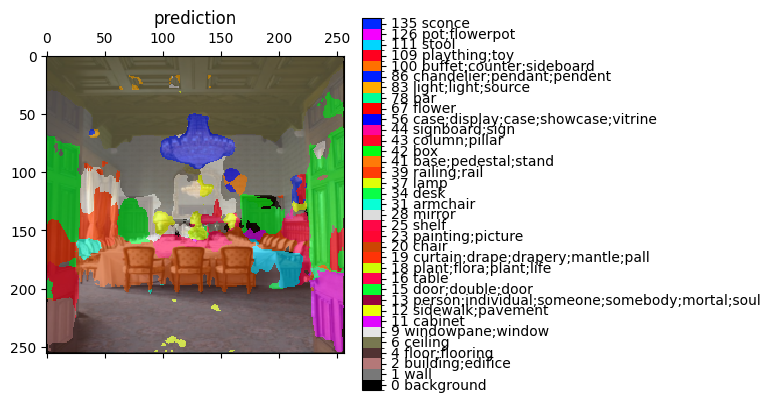

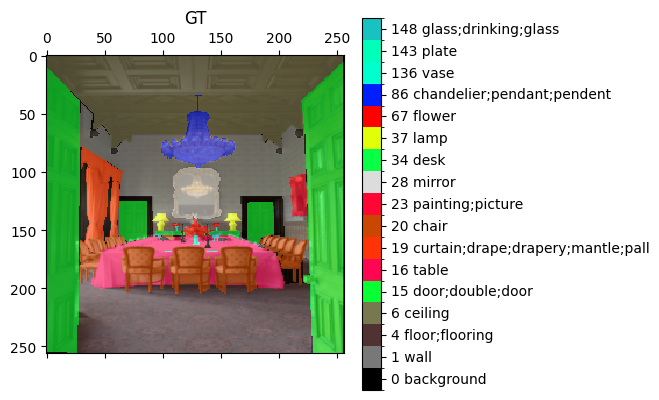

In [15]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=6, dataset='ADE')